In [12]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

train_df = pd.read_csv("part-00000-36d")
val_df = pd.read_csv("./validation/part-00000")

train = train_df.to_numpy()
val = val_df.to_numpy()

train_labels = train[:,0]
train_timestamps = train[:,1]
train_data = train[:,2:]

val_labels = val[:,0]
val_timestamps = val[:,1]
val_data = val[:,2:]

#train_labels = train_labels.reshape(-1,1)

In [2]:
#timestamps without data? 
#Should Add timestamp as a feature. 
def create_input_sequence(input_data, input_labels, timestamps):

    input_data = torch.tensor(input_data, dtype=torch.float32)
    input_labels = torch.tensor(input_labels, dtype=torch.float32)
    
    max_timestamp = int(max(timestamps))

    train_sequence = [[] for i in range(max_timestamp+1)]
    train_labels = [0 for i in range(max_timestamp+1)]

    for i in range(len(input_data)):
        timestamp = int(timestamps[i])
        train_sequence[timestamp].append(input_data[i])
        train_labels[timestamp] = input_labels[i]

    for i in range(len(train_sequence)):
        if train_sequence[i]:
            train_sequence[i] = torch.stack(train_sequence[i], dim=0)
    
    # print(train_sequence)
    #Calculate mean of each timestep, could try to use encoder-decoder 
    for i in range(len(train_sequence)):
        train_sequence[i] = torch.mean(train_sequence[i], dim=0)
    
    # #First pad, since the data entries in each week is different.
    # #pad_train_sequence = pad_sequence(train_sequence)

    train_sequence = torch.stack(train_sequence)
    train_labels = torch.stack(train_labels, dim=0)
    # train_labels = train_labels.view(-1,1)

    return train_sequence, train_labels

In [13]:
from torch.nn.utils.rnn import pad_sequence

#timestamps without data? 
#Should Add timestamp as a feature. 
def create_input_sequence_ticketed(input_data, input_labels, timestamps):

    input_data = torch.tensor(input_data, dtype=torch.float32)
    input_labels = torch.tensor(input_labels, dtype=torch.float32)
    
    max_timestamp = int(max(timestamps))

    train_sequence = [[] for i in range(max_timestamp+1)]
    train_labels = [0 for i in range(max_timestamp+1)]

    for i in range(len(input_data)):
        timestamp = int(timestamps[i])
        train_sequence[timestamp].append(input_data[i])
        train_labels[timestamp] = input_labels[i]

    for i in range(len(train_sequence)):
        if train_sequence[i]:
            train_sequence[i] = torch.stack(train_sequence[i], dim=0)
    
    # print(train_sequence)
    #Calculate mean of each timestep, could try to use encoder-decoder 
    for i in range(len(train_sequence)):
        if len(train_sequence[i]) == 0:
            train_sequence[i] = train_sequence[i-1]
            train_labels[i] = train_labels[i-1]
        else:
            train_sequence[i] = torch.mean(train_sequence[i], dim=0)
    
    # #First pad, since the data entries in each week is different.
    # #pad_train_sequence = pad_sequence(train_sequence)

    train_sequence = torch.stack(train_sequence)
    train_labels = torch.stack(train_labels, dim=0)
    # train_labels = train_labels.view(-1,1)

    return train_sequence, train_labels

In [14]:
data_x, data_y = create_input_sequence_ticketed(train_data, train_labels, train_timestamps)

#Should NOT normalize validation data?
data_x = (data_x - data_x.mean(axis=0)) / data_x.std(axis=0)
data_y = (data_y - data_y.mean(axis=0)) / data_y.std(axis=0)

In [15]:
data_x = data_x.cpu().detach().numpy()
data_y = data_y.cpu().detach().numpy()

train_size = len(data_x) // 4 * 3

train_x, train_y = data_x[:train_size], data_y[:train_size]
val_x, val_y = data_x[train_size:], data_y[train_size:]

In [16]:
import xgboost
import os
 
#model = xgboost.XGBRegressor(n_estimators=30, objective="reg:squarederror")
model = xgboost.XGBRegressor()

In [17]:
model.fit(train_x, train_y)

[15:48:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [18]:
pred_y = model.predict(data_x)

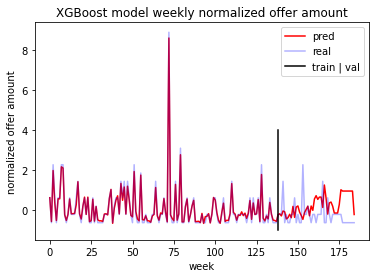

In [19]:
import matplotlib.pyplot as plt

train_size = len(data_x) // 4 * 3
plt.plot()
plt.xlabel('week')
plt.ylabel('normalized offer amount')
plt.title('XGBoost model weekly normalized offer amount')
plt.plot(pred_y, 'r', label='pred')
plt.plot(data_y, 'b', label='real', alpha=0.3)
plt.plot([train_size, train_size], [-1, 4], color='k', label='train | val')
plt.legend()
plt.savefig('XGBoost_ticketed.png')


In [20]:
diff_y = pred_y[train_size:] - data_y[train_size:]
l1_loss = np.mean(np.abs(diff_y))
l2_loss = np.mean(diff_y ** 2)
print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

L1: 0.771    L2: 0.992


In [12]:
from sklearn.metrics import r2_score

r2_score(data_y[train_size:], pred_y[train_size:])

-0.1479505742419438